In [3]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from gensim.models import Word2Vec
from scipy.stats import mode
import matplotlib.pyplot as plt
import requests
from PIL import Image
from io import BytesIO
import warnings
import gensim
import pickle
from scipy.io import mmread
warnings.filterwarnings(action='ignore')

## TFIDF 모델 불러오기

[('미식축구', 0.6325036883354187), ('카레이싱', 0.6226170063018799), ('동계', 0.6209433674812317), ('메이저', 0.6180950999259949), ('레슬링', 0.6153277158737183), ('미식', 0.6074758768081665), ('금메달', 0.6072795987129211), ('본선', 0.6055942177772522), ('풋볼', 0.6050070524215698), ('합숙', 0.6021332740783691)]
['미식축구', '카레이싱', '동계', '메이저', '레슬링', '미식', '금메달', '본선', '풋볼', '합숙']
스포츠 스포츠 스포츠 스포츠 스포츠 스포츠 스포츠 스포츠 스포츠 스포츠 미식축구 미식축구 미식축구 미식축구 미식축구 미식축구 미식축구 미식축구 미식축구 카레이싱 카레이싱 카레이싱 카레이싱 카레이싱 카레이싱 카레이싱 카레이싱 동계 동계 동계 동계 동계 동계 동계 메이저 메이저 메이저 메이저 메이저 메이저 레슬링 레슬링 레슬링 레슬링 레슬링 미식 미식 미식 미식 금메달 금메달 금메달 본선 본선 풋볼
   movie_id          title  year  star movie_rating             genre  \
0    100676           폭스캐처  2015  8.19     청소년 관람불가          드라마, 스릴러   
1     46132      슈퍼히어로의 진실  2014  8.17      15세 관람가             다큐멘터리   
2    154293         아이, 토냐  2018  8.51     청소년 관람불가               드라마   
3    151751          로건 럭키  2018  7.56      12세 관람가  코미디, 범죄, 드라마, 액션   
4    193805  하이큐!! 또 다른 도전  2020  6.84      12세 관람가     

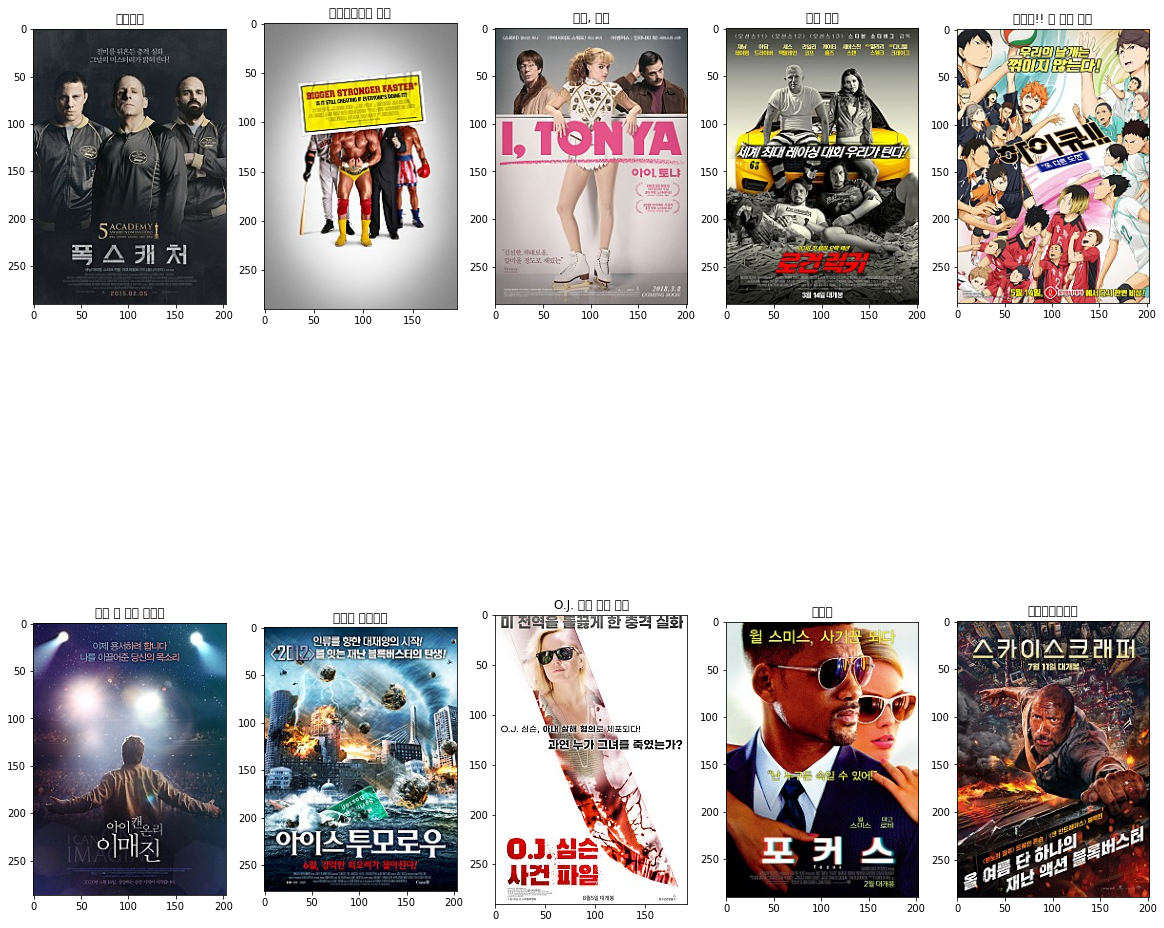

In [6]:
# 데이터 불러오기
df_review_one_sentence = pd.read_csv(
    "C:/Users/82104/Documents/Sessac/자연어처리/가상환경/1st_project/model/쟝고/movie_data_final.csv", index_col=0)
df_review_one_sentence.reset_index(inplace = True, drop = True)

def getRecommendation(cosine_sim):
    simScores = list(enumerate(cosine_sim[-1])) 
    # 가장 높은 유사도 추출
    simScores = sorted(simScores, key=lambda x:x[1], 
                       reverse=True)
    
    # 가장 높은 유사도 40개 추출
    simScores = simScores[1:40]
    movieidx = [i[0] for i in simScores]
    RecMovielist = df_review_one_sentence.iloc[movieidx].reset_index(drop = True)
    
    # topic_mode = 가장 높은 유사도의 lda_topic
    topic_mode = mode(RecMovielist['lda_topic'])[0]
    res = []
    for i in movieidx:
        # 키워드와의 높은 유사도를 가진 값들 중 lda topic값이 같은 것들만 추출(10개)
        if df_review_one_sentence['lda_topic'].loc[i] == topic_mode[0]:
            res.append(i)
            if len(res) ==10:
                break
    RecMovielist = df_review_one_sentence.iloc[res].reset_index(drop = True)
    print(RecMovielist)
    
    # subplot으로 추출된 영화 포스터 visualization
    fig = plt.figure(figsize=(20,20))
    for index, row in RecMovielist.iterrows():
        response = requests.get(row['image_link'])
        img = Image.open(BytesIO(response.content))
        fig.add_subplot(2, 5, index + 1)
        plt.imshow(img)
        plt.title(row['title'])
    return df_review_one_sentence['title'][movieidx]

# 이전에 학습한 embedding model 불러오기
embedding_model = Word2Vec.load("C:/Users/82104/Documents/Sessac/자연어처리/가상환경/1st_project/model/final/word2VecModel_final.model")

# 키워드 입력
key_word = '스포츠'
sentence = [key_word] * 10

# 유사도가 높은 단어 순으로 가중치(keyword의 갯수)를 사용해 keyword와 유사도 높은 영화 찾기
if key_word in embedding_model.wv.index_to_key:
    sim_word = embedding_model.wv.most_similar(key_word, topn=10)
    print(sim_word)
    labels = []
    for label, _ in sim_word:
        labels.append(label)
    print(labels)
    for i, word in enumerate(labels):
        sentence += [word] * (9-i)
sentence = ' '.join(sentence)
print(sentence)

# 이전에 학습한 TFIDF 모델 호출
with open("C:/Users/82104/Documents/Sessac/자연어처리/가상환경/1st_project/model/final/tfidf.pickle", "rb") as fr:
    Tfidf = pickle.load(fr)
Tfidf_matrix = mmread("C:/Users/82104/Documents/Sessac/자연어처리/가상환경/1st_project/model/final/tfidf_movie_review.mtx")

# TFIDF 모델 transform
sentence_vec = Tfidf.transform([sentence])

# 코사인 유사도 계산
cosine_sim = linear_kernel(sentence_vec,
                           Tfidf_matrix)
recommendation = getRecommendation(cosine_sim)
print(recommendation)